Sample code on small test dataset for processing and visualizing experimental results, to be adapted into scripts for Fiji.

In [886]:
# Imports
import json
import numpy as np
import plotly.plotly as py
import matplotlib as mpl
mpl.use('Agg')
from matplotlib import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import os
import glob2
import re

/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




### Load in data from a single set of parameters.

In [697]:
def load_config_measurements(experiment_dir, replicate_i):

    ''' This function loads in data from a single experiment given 
    the directory path and replicate number. Returns a dictionary 
    of a single replicate containing: model parameter configurations, 
    distance from queen & from other workers. 
    '''
    
    # Load config.json
    with open(experiment_dir + "/config.json", "r") as f:
        config_dict = json.load(f)
        
    # Pull out params of interest from config.json
    D = config_dict['diffusion_coefficient']
    Q = config_dict['swarm_parameters']['queen_bee_concentration']
    W = config_dict['swarm_parameters']['worker_bee_concentration']
    T = config_dict['swarm_parameters']['worker_bee_threshold']
    
    # Load measurements.json
    with open(experiment_dir + "/data/measurements.json", "r") as f:
        measurements = json.load(f)
        
    # Pull out params of interest from measurements.json
    distance_from_queen = measurements['distance_from_queen']
    distance_from_others = measurements['distance_from_others']
    
    # Create dict 
    parameters = ['diffusion_coefficient', 'queen_bee_concentration',
         'worker_bee_concentration', 'worker_bee_threshold',
         'distance_from_queen', 'distance_from_others']
    values = [D, Q, W, T, distance_from_queen, distance_from_others]
    experiment_dict = dict(zip([p for p in parameters], values))
    outer_dict = {"Replicate {}".format(replicate_i) : experiment_dict}
    
    return outer_dict

In [698]:
# Test above function
experiment_dir = "experiments/05M_24D-13H_48M_06S/experiment0_Q0.01_W0.005_D0.05_T0.001"
d = load_config_measurements(experiment_dir, 1)
d["Replicate 1"]['queen_bee_concentration']

0.01

### Store all (10) replicates of a single set of parameters in a list. Save to a JSON file. Ultimately, total: 256 JSON files of different parameter combinations. 

In [705]:
# All data folders: ultimately 2560
data_folders = glob2.glob("experiments/*/*")
data_folders

# Other ways:
# data_folders = list(map(lambda x : x.split("/")[-1], glob2.glob("experiments/run*/*")))
# data_folders = [ele.split("/")[-1] for ele in glob2.glob("experiments/run*/*")]

['experiments/05M_24D-13H_48M_06S/experiment0_Q0.01_W0.005_D0.05_T0.001',
 'experiments/05M_24D-13H_48M_06S/experiment1_Q0.5_W0.005_D0.05_T0.001',
 'experiments/05M_24D-16H_04M_42S/experiment0_Q0.01_W0.005_D0.05_T0.001',
 'experiments/05M_24D-16H_04M_42S/experiment1_Q0.5_W0.005_D0.05_T0.001']

In [706]:
# List of 256 unique sets of parameters
sets_list = next(os.walk('experiments/05M_24D-13H_48M_06S/'))[1]
sets_list

['experiment0_Q0.01_W0.005_D0.05_T0.001',
 'experiment1_Q0.5_W0.005_D0.05_T0.001']

In [712]:
def combine_replicates(data_folders, param_set):
    ''' This function finds replicates of a set of parameters across
    all experiment runs. Iteratively calls the function 
    "load_config_measurements" to create a dictionary for a single 
    replicate. Then combine all replicates' data into a list, and write
    to a JSON file for further data analysis. Will run this 256 times for
    256 sets. 
    '''
    
    # List to contain all replicates
    all_replicates = []
    
    # If find the param_set in a data_folders[i], get the index of
    # that data_folders[i] 
    data_folder_i = []
    for i in range(len(data_folders)):
        found_index = data_folders[i].find(param_set)
        if found_index != -1:
            # print(i)
            data_folder_i.append(i)
            
    # Load data using "load_config_measurements"
    for j in range(len(data_folder_i)):
        data = load_config_measurements(data_folders[data_folder_i[j]], j+1)
        all_replicates.append(data)
    
    # Truncate string "param_set" to save as name for json file
    start_char = "Q"
    truncate_name = param_set[param_set.index(start_char):]
    
    # Write the cumulative list containing all replicates to JSON
    with open('combined_replicates_test/{}.json'.format(truncate_name), 'w') as outfile:
        json.dump(all_replicates, outfile)
    
    return None

In [713]:
# Test above function using 2 lists below
for k in sets_list:
    save_lists_json = combine_replicates(data_folders, k)

### Modify the JSONs from "combine_replicates" to scp from fiji and plot in local computer instead

In [989]:
def get_distances(param_set_json):
    
    ''' Load in each JSON created by combine_replicates and only pull out avg distances 
    or distances from others later '''
    
    with open("combined_replicates/" + param_set_json, "r") as f:
        data = json.load(f)
    
    all_distances = []
    for j in range(len(data)):  # Loop over each replicate
        avg_distance = []
        for i in range(160):    # Loop over all the 160 averages/values/lists
            avg_distance.append(data[j]["Replicate {}".format(j+1)]["distance_from_queen"][i]["average"])
        all_distances.append(avg_distance)
    
    
    # Write truncated data to JSON
    start_char = "j"
    filename = f.name
    name = filename[20:filename.index(start_char)]
    
    with open('avg_distance_data/{}json'.format(name), 'w') as outfile:
        json.dump(all_distances, outfile)
    
    return None

In [990]:
# Test above function on all JSON's in dir
get_distances("Q0.01_W0.005_D0.05_T0.001.json")

In [992]:
# Iterate through all (256) JSON's and produce 1 figure each 
reps_list = list(map(lambda x : x.split("/")[-1], glob2.glob("combined_replicates/*")))

for r in reps_list:
    print("Getting avg distances for: {}".format(r))
    get_distances(r)

Getting avg distances for: Q0.01_W0.005_D0.05_T0.001.json
Getting avg distances for: Q0.5_W0.005_D0.05_T0.001.json


### Visual I. Workers' average distance from the queen

For each replicate in a set of parameters, open that cumulative JSON and plot each replicate as a line in a single plot.

In [871]:
plt.style.use('seaborn-white')

plt.rcParams['font.sans-serif'] = "Tahoma"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['lines.linewidth'] = 3
params = {"ytick.color" : "#535956",
          "xtick.color" : "#535956",
          "axes.labelcolor" : "#535956",
          "axes.edgecolor" : "#535956",
          "text.color": "#535956"}
plt.rcParams.update(params)

In [1044]:
def plot_avg_distances(data_json):
    
    ''' For each replicate in a set of parameters, open that cumulative 
    JSON and plot each replicate as a line in a single plot.
    '''
    
    with open("avg_distance_data/" + data_json, "r") as f:
        data = json.load(f)
        
    fig = plt.figure(figsize=(6,4))
    ax = plt.axes()

    start_char = "j"
    filename = f.name
    fig_name = filename[18:filename.index(start_char)]

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for i, d in enumerate(data):
        ax.plot(d, label='Swarm {}'.format(i+1))

        plt.xlim(0, 160)
        plt.ylim(0, 5)

        plt.legend()

        plt.xlabel('Time (step)')
        plt.ylabel('Average distance to queen')
        plt.title('{}'.format(fig_name[:-1]))

        plt.tight_layout()
        plt.savefig("figures/distance_to_queen/{}pdf".format(fig_name), transparent=True)

    plt.close()

In [1046]:
# Iterate through all (256) JSON's and produce 1 figure each 
reps_list = list(map(lambda x : x.split("/")[-1], glob2.glob("combined_replicates/*")))

for r in reps_list:
    print("Plotting average distance to queen for: {}".format(r))
    plot_avg_distances(r)

Plotting average distance to queen for: Q0.01_W0.005_D0.05_T0.001.json
Plotting average distance to queen for: Q0.5_W0.005_D0.05_T0.001.json


### Visual II. 2D phase diagram showing the end distances of swarms

In [111]:
queen_concentration = [0.01, 0.255, 0.5]
worker_concentration = [0.005, 0.2525, 0.5]
swarm_end_distance = np.random.random((3, 3))

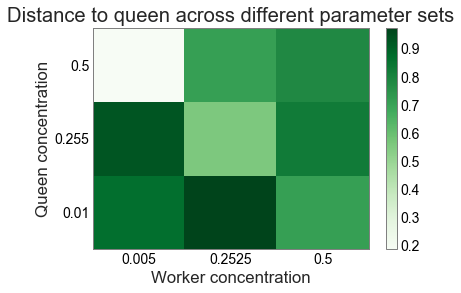

In [581]:
fig, ax = plt.subplots()
#im = ax.imshow(swarm_end_distance)

# We want to show all ticks...
ax.set_xticks(np.arange(len(worker_concentration)))
ax.set_yticks(np.arange(len(queen_concentration)))
# ... and label them with the respective list entries
ax.set_xticklabels(worker_concentration)
ax.set_yticklabels(queen_concentration)

heatmap = ax.pcolor(swarm_end_distance, cmap=plt.cm.Greens)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(swarm_end_distance.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(swarm_end_distance.shape[1])+0.5, minor=False)

ax.set_xlabel('Worker concentration')
ax.set_ylabel('Queen concentration')

fig.colorbar(heatmap)
fig.tight_layout()
plt.title('Distance to queen across different parameter sets')
plt.show()

### Visuals III. Distance between workers over time